<a href="https://colab.research.google.com/github/ZhenZhangz/E4511/blob/main/excape_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring SLC6A3 protein target activity data from ExcapeDB

The Target specific data was downloaded from https://zenodo.org/record/173258#.X_44kuhKi70



In [ ]:
!date # starting time

Wed Mar 17 21:05:39 UTC 2021


## Install AMPL GPU version

```
real	2m59.739s
user	1m48.995s
sys	0m20.614s
```

In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh


TensorFlow 1.x selected.
--2021-04-08 06:51:50--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   183MB/s    in 2.8s    

2021-04-08 06:51:53 (183 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaco

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


InvalidVersionSpec: Invalid version '4.19.112+': empty version component


real	0m11.177s
user	0m7.811s
sys	0m1.782s
--2021-04-08 07:01:04--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.07

In [ ]:
!date

Wed Mar 17 21:12:23 UTC 2021


## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity for the receptor SLC6A3


In [ ]:
! pip install MolVS
! pip install bravado
! pip install UMAP

     |████████████████████████████████| 71kB 4.9MB/s 
  Created wheel for MolVS: filename=MolVS-0.1.1-cp37-none-any.whl size=32376 sha256=83a6968768dc6f0fb4bfa72998f3aa499c8cd8ff749d706e0ef41ea8ae2a7a2d
  Stored in directory: /root/.cache/pip/wheels/30/37/a8/8ac8147605c9de6b45ffd66d1cc19761d41467db12b34a0de8
Successfully built MolVS
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 133kB 17.1MB/s 
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=2cfb2bf832b4dfb7f8bbe236d6aaeb83a966ff035055216298fa79143209af00
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339
  Created wheel for UMAP: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=37c24a28c5cb90ab3e9373b44a80d06b86f009a8bf6a9a21fba9a66ec45b221d
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94cca

In [ ]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import requests

In [ ]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

## Select a target to work with 


# Define data locations 
## This data has 'rdkit_base_smiles' and drooped the empty rows.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the downloaded content and turning it into a pandas dataframe
orig_df = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/SLC6A4_Excape_SMILES.csv")


In [ ]:
print(sum(orig_df['pXC50'].isna()) )
print(len(orig_df) - sum(orig_df['pXC50'].isna()))
# it is probably not a good idea if i have 100k of empty value for pXC50
len(orig_df)

13
7597


7610

### Load target data into a pandas data frame

In [ ]:
# orig_df=pd.read_csv(file,sep="\t",engine="python",error_bad_lines=False)
#show number of rows in data frame and number of columns
print(orig_df.shape)

# show column names
display(orig_df.columns)

(7610, 13)


Index(['Unnamed: 0', 'Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID',
       'Activity_Flag', 'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID',
       'Gene_Symbol', 'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [ ]:
display(orig_df)

,Unnamed: 0,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
0,0,ZBQKBFQDMGBNRL-UHFFFAOYNA-N,17904246,6532,N,NaN,pubchem,738127,9606,SLC6A4,4061,FC=1C=C2C(CCC)=CNC2=CC1,CCCc1c[nH]c2ccc(F)cc12
1,1,CWYBNSVSYKQGJB-UHFFFAOYNA-N,71541095,6532,A,6.85387,pubchem,727355,9606,SLC6A4,4061,ClC=1C=C(C2CCCCNC2)C=CC1Cl,Clc1ccc(C2CCCCNC2)cc1Cl
2,2,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6532,A,6.37000,chembl20,774720,9606,SLC6A4,4061,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl,Clc1cc(Cl)c(OCC#CI)cc1Cl
3,3,DTEDVKORISMLCH-UHFFFAOYNA-N,CHEMBL1078352,6532,N,4.75000,chembl20,622498,9606,SLC6A4,4061,C(C(CC)N)C=1C=CC(=CC1)SC,CCC(N)Cc1ccc(SC)cc1
4,4,FQDRMHHCWZAXJM-UHFFFAOYNA-N,125558,25553,A,9.98297,pubchem,205028,10116,SLC6A4,4061,O1C=2C=C3CC(N)CC3=CC2OC1,NC1Cc2cc3c(cc2C1)OCO3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7605,7605,VZAQFIJMTJXBKF-RFDWHHNUNA-N,46226549,6532,A,6.60206,pubchem,450452,9606,SLC6A4,4061,S1C=C(C2=CC=C([C@@H]3[C@@H](C4N(C(C3)CC4)C)C(=...,CN1C2CCC1[C@@H](C(=O)NCCCCCCCCCCNC(=O)[C@H]1C3...
7606,7606,ZFJXYVKPCIOHJP-QRFGNDMPNA-N,CHEMBL595767,6532,A,6.80000,chembl20,601510,9606,SLC6A4,4061,[C@H]1(C2CCC(N2C)C[C@@H]1C3=CC=C(C4=CSC=C4)C=C...,CN1C2CCC1[C@@H](C(=O)NCc1ccc(CNC(=O)[C@H]3C4CC...
7607,7607,ZERAVOYPKCPVKA-QPQDOQCTNA-N,CHEMBL611963,6532,A,6.14000,chembl20,601510,9606,SLC6A4,4061,C1C2N(C)C([C@H](C(=O)NCC3=CC=C(C=C3)NC([C@@H]4...,CN1C2CCC1[C@@H](C(=O)Nc1ccc(CNC(=O)[C@H]3C4CCC...
7608,7608,WOXOMROGQFUOGC-XXUSJXAVNA-N,CHEMBL2371923,25553,N,4.49000,chembl20,376177,10116,SLC6A4,4061,[C@@H](C(N[C@H](C(N1[C@@H](CCC1)C(=O)N[C@H](C(...,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...


## For ExCAPE-DB Drop all pxc 50 with null values

In [ ]:
save_df=orig_df

save_df = save_df[save_df['pXC50'].notna()]
len(save_df)
sum(save_df['base_rdkit_smiles'].isna()) # there is no empty rdkit smiles
save_df.to_csv('EXCAPE_SLC6A3_SMILES_DROPNA')

## What does get.smiles_excape_data function do? 

*   Expects a 'pXC50' column
*   Applies **dropna** to `pXC50` column
*   standardizes by calling **struct_utils.base_smiles_from_smiles** and converts **SMILES** column and writes it out as a new column called **rdkit_smiles** 
** Will return a list that contains a DF (with added column, **rdkit_smiles** and a list of InChiKey

In [ ]:
# there is already rdkiut smiles
# slst,klst=dcf.get_smiles_excape_data(save_df,[target_name])
# save_smiles_df=slst[0]

## If needed, create smaller dataset

In [ ]:
# comment the following two code lines in system with memory constraints or for testing
# make a copy 
save_smiles_df = save_df
save_smiles_df_copy = save_smiles_df
save_smiles_df = save_smiles_df.sample(frac=0.5, random_state=1)

In [ ]:
## We need to save this format with the RDKIT conanonical SMILES
save_smiles_df.to_csv("frac_excape.csv",index=False)

### Now the PIC50 column is created above with this function call

# Export this Image to a  PNG to upload to slide deck for comparison


Post-processing dataset

Total Number of results = 3798
dataset mean = 7.087900966297998 NM
dataset stdev = 1.3092037869443065 NM
dataset max = 11.7 NM
dataset min = 2.33 NM



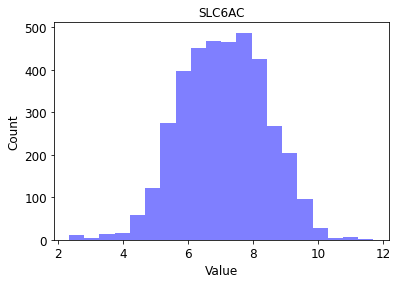

In [ ]:
# Our outcome is pXC50 
column = 'pXC50'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 20

target_name = 'SLC6AC'
# Ue the target_name as the title for the plot 
title = target_name

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'NM'

# filepath, in this case, current dir
filepath = ""

# save_smiles_df was defined earlier
data=save_smiles_df

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of pXC50)
#   dataset stdev: (sd of pXC50)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [ ]:
data.rename( columns={ "Ambit_InchiKey" : "compound_id" }, inplace=True)

curated_file = "frac_excape.csv"
data.head(5)

,Unnamed: 0,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
3080,3080,DRWJMJVERMOJBX-SFHVURJKNA-N,24962988,6532,A,5.95468,pubchem,430249,9606,SLC6A4,4061,O(C(=O)N([C@H]1CCNC1)CC=2C(C3=CC=CC=C3)=CC=CC2)CC,CCOC(=O)N(Cc1ccccc1-c1ccccc1)[C@H]1CCNC1
933,933,PHVGLTMQBUFIQQ-UHFFFAOYNA-N,CHEMBL445,6532,A,8.16000,chembl20,774720,9606,SLC6A4,4061,C1(C2=C(CCC3=C1C=CC=C3)C=CC=C2)=CCCNC,CNCCC=C1c2ccccc2CCc2ccccc21
6351,6351,RUVPTFYWDPFBOR-ZQWZXOJDNA-N,CHEMBL2113052,25553,A,6.10000,chembl20,303160,10116,SLC6A4,4061,[C@@H]1(OC[C@H](C(C1)NCC2=CC=C(C=C2)OC)O)C(C=3...,COc1ccc(CNC2C[C@@H](C(c3ccccc3)c3ccccc3)OC[C@H...
425,425,QLXIMJBRAWACSR-UHFFFAOYNA-N,11514389,6532,A,7.74473,pubchem,393258,9606,SLC6A4,4061,O1C(CCC1CN)CCC=2C=3C(C=CC2)=CC=CC3,NCC1CCC(CCc2cccc3ccccc23)O1
869,869,OWJCWMVVFCUPBX-UHFFFAOYNA-N,10263646,6532,A,8.07058,pubchem,537602,9606,SLC6A4,4061,N(C1CC(CC1)C=2C=3C(NC2)=CC=C(C3)C#N)C,CNC1CCC(c2c[nH]c3ccc(C#N)cc23)C1


In [ ]:
# column: Response values column
column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# column that will be averaged ; smiles_col; used to find the replicates
# 

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# curated_file = os.path.join(working_dir, ofile)
## discard out of range values
curated_df=curated_df[curated_df['VALUE_NUM_mean']>2]
curated_df.to_csv(curated_file, index=False)
curated_df.head()


Bad duplicates removed from dataset
Dataframe size (3770, 17)
List of 'bad' duplicates removed
                      compound_id     pXC50  ...   Perc_Var  VALUE_NUM_std
3531  FFWFFOAMLOOINZ-UHFFFAOYNA-N   8.80000  ...  13.037893       1.435427
1670  FFWFFOAMLOOINZ-UHFFFAOYNA-N   6.77000  ...  13.037893       1.435427
707   FUPSDUNHOVTEQY-UHFFFAOYNA-N   6.15366  ...  13.288892       1.020822
2500  FUPSDUNHOVTEQY-UHFFFAOYNA-N   4.71000  ...  13.288892       1.020822
3260  IHCJKFBOZVVXQM-UHFFFAOYNA-N   2.67000  ...  26.547455       1.364716
2727  IHCJKFBOZVVXQM-UHFFFAOYNA-N   4.60000  ...  26.547455       1.364716
2655  ITJNARMNRKSWTA-UHFFFAOYNA-N   6.56000  ...  14.860480       1.619275
2607  ITJNARMNRKSWTA-UHFFFAOYNA-N   8.85000  ...  14.860480       1.619275
2953  JEIPZRACKXFYIK-UHFFFAOYNA-N   6.35458  ...  10.860891       1.094962
1352  JEIPZRACKXFYIK-UHFFFAOYNA-N   7.90309  ...  10.860891       1.094962
1397  LVZJJQJUGMAHIF-UHFFFAOYNA-N   7.26000  ...   8.908407       1.004092
1862 

,Unnamed: 0,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,3080,DRWJMJVERMOJBX-SFHVURJKNA-N,24962988,6532,A,5.95468,pubchem,430249,9606,SLC6A4,4061,O(C(=O)N([C@H]1CCNC1)CC=2C(C3=CC=CC=C3)=CC=CC2)CC,CCOC(=O)N(Cc1ccccc1-c1ccccc1)[C@H]1CCNC1,5.95468,NaN,0.0,0
1,933,PHVGLTMQBUFIQQ-UHFFFAOYNA-N,CHEMBL445,6532,A,8.16000,chembl20,774720,9606,SLC6A4,4061,C1(C2=C(CCC3=C1C=CC=C3)C=CC=C2)=CCCNC,CNCCC=C1c2ccccc2CCc2ccccc21,8.16000,NaN,0.0,0
2,6351,RUVPTFYWDPFBOR-ZQWZXOJDNA-N,CHEMBL2113052,25553,A,6.10000,chembl20,303160,10116,SLC6A4,4061,[C@@H]1(OC[C@H](C(C1)NCC2=CC=C(C=C2)OC)O)C(C=3...,COc1ccc(CNC2C[C@@H](C(c3ccccc3)c3ccccc3)OC[C@H...,6.10000,NaN,0.0,0
3,425,QLXIMJBRAWACSR-UHFFFAOYNA-N,11514389,6532,A,7.74473,pubchem,393258,9606,SLC6A4,4061,O1C(CCC1CN)CCC=2C=3C(C=CC2)=CC=CC3,NCC1CCC(CCc2cccc3ccccc23)O1,7.74473,NaN,0.0,0
4,869,OWJCWMVVFCUPBX-UHFFFAOYNA-N,10263646,6532,A,8.07058,pubchem,537602,9606,SLC6A4,4061,N(C1CC(CC1)C=2C=3C(NC2)=CC=C(C3)C#N)C,CNC1CCC(c2c[nH]c3ccc(C#N)cc23)C1,8.07058,NaN,0.0,0


## Note this includes the compounds discarded by measurement variation and out of range values

In [ ]:
curated_df

,Unnamed: 0,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,3080,DRWJMJVERMOJBX-SFHVURJKNA-N,24962988,6532,A,5.95468,pubchem,430249,9606,SLC6A4,4061,O(C(=O)N([C@H]1CCNC1)CC=2C(C3=CC=CC=C3)=CC=CC2)CC,CCOC(=O)N(Cc1ccccc1-c1ccccc1)[C@H]1CCNC1,5.95468,NaN,0.0,0
1,933,PHVGLTMQBUFIQQ-UHFFFAOYNA-N,CHEMBL445,6532,A,8.16000,chembl20,774720,9606,SLC6A4,4061,C1(C2=C(CCC3=C1C=CC=C3)C=CC=C2)=CCCNC,CNCCC=C1c2ccccc2CCc2ccccc21,8.16000,NaN,0.0,0
2,6351,RUVPTFYWDPFBOR-ZQWZXOJDNA-N,CHEMBL2113052,25553,A,6.10000,chembl20,303160,10116,SLC6A4,4061,[C@@H]1(OC[C@H](C(C1)NCC2=CC=C(C=C2)OC)O)C(C=3...,COc1ccc(CNC2C[C@@H](C(c3ccccc3)c3ccccc3)OC[C@H...,6.10000,NaN,0.0,0
3,425,QLXIMJBRAWACSR-UHFFFAOYNA-N,11514389,6532,A,7.74473,pubchem,393258,9606,SLC6A4,4061,O1C(CCC1CN)CCC=2C=3C(C=CC2)=CC=CC3,NCC1CCC(CCc2cccc3ccccc23)O1,7.74473,NaN,0.0,0
4,869,OWJCWMVVFCUPBX-UHFFFAOYNA-N,10263646,6532,A,8.07058,pubchem,537602,9606,SLC6A4,4061,N(C1CC(CC1)C=2C=3C(NC2)=CC=C(C3)C#N)C,CNC1CCC(c2c[nH]c3ccc(C#N)cc23)C1,8.07058,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,2913,YKTFTKYTVUHUCP-UHFFFAOYNA-N,CHEMBL555565,6532,A,7.60000,chembl20,582670,9606,SLC6A4,4061,C=1(C=CC=2NC=CC2C1)N(C3CCNCC3)C(C=4C=CC=CC4)=O,O=C(c1ccccc1)N(c1ccc2[nH]ccc2c1)C1CCNCC1,7.60000,NaN,0.0,0
3766,6817,GCRWOSGGZZJFKD-GIILIPBQNA-N,CHEMBL3084608,25553,A,6.13000,chembl20,201825,10116,SLC6A4,4061,N1([C@H]2C[C@H](C[C@@H]1CC2)OC(C=3C=CC(=CC3)Cl...,CCCCc1cccc(N2[C@H]3CC[C@@H]2C[C@@H](OC(c2ccccc...,6.13000,NaN,0.0,0
3767,1367,HEFDYDISPNHKAM-UHFFFAOYNA-N,CHEMBL369997,6532,A,5.71000,chembl20,334927,9606,SLC6A4,4061,C1CCN(C(C(C=2C=CC(=CC2)C3=CC=CS3)=O)CCC)C1,CCCC(C(=O)c1ccc(-c2cccs2)cc1)N1CCCC1,5.71000,NaN,0.0,0
3768,295,QVLUCFDUEMLOPB-UHFFFAOYNA-N,CHEMBL3298870,25553,A,6.45000,chembl20,1367806,10116,SLC6A4,4061,C(C(C)NC1CC1)(=O)C2=CC(=C(C=C2)Cl)Cl,CC(NC1CC1)C(=O)c1ccc(Cl)c(Cl)c1,6.45000,NaN,0.0,0


In [ ]:
curated_df['Remove_BadDuplicate'].value_counts()
curated_df.to_csv('drive/MyDrive/Excape_Curated.csv')

In [ ]:
compound_id='base_rdkit_smiles'
reject=data[~data[compound_id].isin(curated_df[compound_id])]
reject # this is the rows we wanna discard

,Unnamed: 0,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
1066,1066,USYMRZQDAPXSPI-UHFFFAOYNA-N,CHEMBL142158,25553,A,10.30000,chembl20,198051,10116,SLC6A4,4061,C=1(SC=2C(CN(C)C)=CC=CC2)C=C(F)C(=CC1N)Cl,CN(C)Cc1ccccc1Sc1cc(F)c(Cl)cc1N
40,40,MLNFJHDSSYRDFN-UHFFFAOYNA-N,CHEMBL1078099,25553,A,5.27000,chembl20,622494,10116,SLC6A4,4061,NC(CC)C=1C=CC(=CC1)SCCCCC,CCCCCSc1ccc(C(N)CC)cc1
2754,2754,UOGHZTJKVOOTDF-LBPRGKRZNA-N,49866085,6532,A,6.18046,pubchem,504077,9606,SLC6A4,4061,ClC=1C=C([C@@H](N2N=C(N=N2)N3N=CC=N3)CCNC)C=CC1Cl,CNCC[C@@H](c1ccc(Cl)c(Cl)c1)n1nnc(-n2nccn2)n1
4316,4316,MZVZZQMOBNGKQR-UHFFFAOYNA-N,CHEMBL105204,6532,A,7.70000,chembl20,201366,9606,SLC6A4,4061,C1(=CNC2=C1C=CC(F)=C2)C3=CCN(CC3)CCOC=4C5=C(OC...,Fc1ccc2c(C3=CCN(CCOc4cccc5c4OCCO5)CC3)c[nH]c2c1
91,91,FUPSDUNHOVTEQY-UHFFFAOYNA-N,44613066,25553,A,6.15366,pubchem,471630,10116,SLC6A4,4061,S(C1=CC=C(CC(NC2CC2)C)C=C1)C,CSc1ccc(CC(C)NC2CC2)cc1
3429,3429,MZVZZQMOBNGKQR-UHFFFAOYNA-N,10271949,25553,A,9.82391,pubchem,204529,10116,SLC6A4,4061,FC1=CC=2NC=C(C=3CCN(CC3)CCOC=4C=5OCCOC5C=CC4)C...,Fc1ccc2c(C3=CCN(CCOc4cccc5c4OCCO5)CC3)c[nH]c2c1
4149,4149,JEIPZRACKXFYIK-UHFFFAOYNA-N,11373342,25553,A,7.90309,pubchem,388702,10116,SLC6A4,4061,FC1=C2OCC(N(CCCC=3C=4C(NC3)=CC=C(F)C4)CCC)CC2=...,CCCN(CCCc1c[nH]c2ccc(F)cc12)C1COc2c(F)ccc(OC)c2C1
1508,1508,LVZJJQJUGMAHIF-UHFFFAOYNA-N,CHEMBL113382,6532,A,7.26000,chembl20,142620,9606,SLC6A4,4061,S(C1=C(C=C(C=C1)Cl)CO)C=2C(CN(C)C)=CC=CC2,CN(C)Cc1ccccc1Sc1ccc(Cl)cc1CO
4521,4521,QSUBPHSKNHPROP-UHFFFAOYNA-N,CHEMBL394322,25553,A,8.89000,chembl20,455313,10116,SLC6A4,4061,C1(OCCCN2CCCCC2)=CC=C(C=C1)C(CCN(C)C)OC3=CC=C(...,CN(C)CCC(Oc1ccc(F)cc1)c1ccc(OCCCN2CCCCC2)cc1
271,271,FFWFFOAMLOOINZ-UHFFFAOYNA-N,CHEMBL278080,6532,A,6.77000,chembl20,90012,9606,SLC6A4,4061,C=1(C=2C(=CC=C(C2)F)NC1)CC3CCNCC3,Fc1ccc2[nH]cc(CC3CCNCC3)c2c1


## save rejected molecules for further examination

In [ ]:
print("Number of discarded compounds",reject[compound_id].nunique())
# ofile=tmp_dir+target_name+'.reject_check.'+username
ofile=target_name+'.reject_check.csv'
reject.to_csv(ofile,index=False)

Number of discarded compounds 14


(0.0, 12.0)

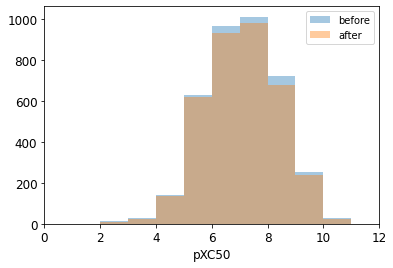

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# This will be our before curation
before=data["pXC50"]

# current curated dataframe will not include any out of range values
after=curated_df["pXC50"]

sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')
plt.legend()
ax.set_xlim([0, 12])

## Let us cluster the compounds to explore the chemical space


Project compounds into two dimensions with UMAP and Tanimoto similiarty

1.   Cluster compounds by Tanimoto similarity
2.   Repeat steps 1 and 2 with Maximum Common Substructure distance when dataset size is below # threshold (default < 300)

See documentation here:
 https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots

 </li>

# Save output from clustering heatmap to image and upload to presentation

In [ ]:
# ifile=tmp_dir+target_name+'_excape.csv.'+username
ifile="frac_excape.csv"

# Plot self similarity (Tanimoto) within dataset and show distribution of distances between compounds in dataset for nearest neighbor.

## Save  distribution plot as an image.

We will be calling dp.diversity_function from AMPL in the following code chunk. For AMPL function explanations, 
please consult AMPL documentation here, https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots 

## Here is a brief explanation of `dp` function: 

### The AMPL function will calculate diversity profile for the data. 

### Input Args:


*   **dset_key:** : Name of the input data variable 
*   **datastore** : 
*   **id_col**    : Ambit_InchiKey, it is a chemical identifier for the compound or drug molecules. Please check here for a detailed explanation of InChiKey, https://en.wikipedia.org/wiki/International_Chemical_Identifier#:~:text=%2B%2Fm0%2Fs1-,InChIKey,hashed%20counterpart%20of%20standard%20InChI. In this case, Excape is using InChiKey generated from Ambit
*   **response_col**: Outcome column, in out case it is pXC50

## `dp.diversity_plots` function

*    Computes Fingerprints 
*    If the number of compounds are > 300, it will compute Fingerprints and use it to compute Tanimoto distance matrix. plot the distances using UMAP projection and cluster (complete cluster method will be used) the distances to create a heatmap
*   If the number of compounds are < 300, MCS (Maximum Common Substructure) will be in addition the above step. 


## Helpful links

* Tanimoto 
    * https://en.wikipedia.org/wiki/Jaccard_index
    * https://en.wikipedia.org/wiki/Chemical_similarity
* UMAP
    * https://pair-code.github.io/understanding-umap/
* MCS
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2718661/ 

In [ ]:
x_del = pd.read_csv(ifile)

In [ ]:
x_del.columns

Index(['Unnamed: 0', 'compound_id', 'Original_Entry_ID', 'Entrez_ID',
       'Activity_Flag', 'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID',
       'Gene_Symbol', 'Ortholog_Group', 'SMILES', 'base_rdkit_smiles',
       'VALUE_NUM_mean', 'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate'],
      dtype='object')

In [ ]:
dp.diversity_plots(dset_key=ifile,datastore=False,id_col='compound_id',response_col='pXC50',smiles_col = 'base_rdkit_smiles')

Canonicalizing 3653 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


AttributeError: ignored

## Self similarity (Tanimoto) 

Calculate self-similarity (using Tanimoto) for the dataset and plot the distanes. 

In [ ]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = save_smiles_df['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

In [ ]:
print(len(dist_sample))
print(len(smiles_lst1))

3798
3798


## What does **calc_dist_smiles** function return? 


*   input is a list of SMILES strings
*   data featurization: ECFP (Fingerprint)
*   What distance metric to use? Tanimoto
*   How to process distance matrix, nearest ?
*   returns a distance matrix as a vector of distances

Here is the function summary:

*   rdkit is used to transform SMILES to mols
*   mols to FP (Morgan, 1024 FP)
*   calls calc_summary with the following options: 
         * fprints1 is the FP 
         * fprints2 is none 
         * dist_metrics will return a distance matrix
    calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type=nearest, num_nearest=1, within_dset=True)

* Finally, returns the distances of each atom to its closest neighbor 



## Explanation for the following code chunk

* **scipy.stats.kde** will use kernel density function to estimate the probability density function (PDE)
---



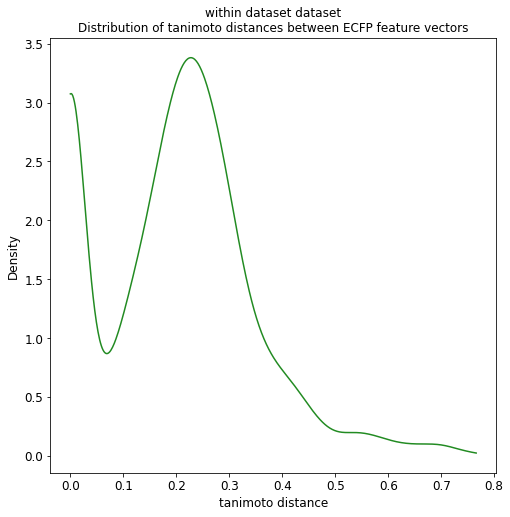

In [ ]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [ ]:
!date # ending time

Wed Mar 17 21:44:03 UTC 2021
